In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/train', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val = val_test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/val', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test = val_test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


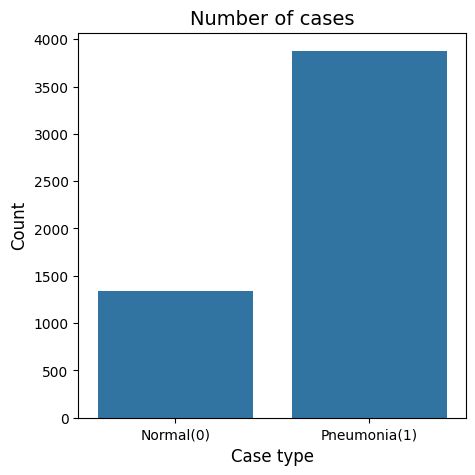

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
# Get the counts for each class in the training data
cases_count = np.bincount(train.classes)  # 'classes' attribute of DirectoryIterator

# Create a series with class names for plotting
cases_count_series = pd.Series(cases_count, index=['Normal(0)', 'Pneumonia(1)'])

# Plot the results
plt.figure(figsize=(5, 5))
sns.barplot(x=cases_count_series.index, y=cases_count_series.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count_series.index)), cases_count_series.index)
plt.show()

In [ ]:
print(train.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}


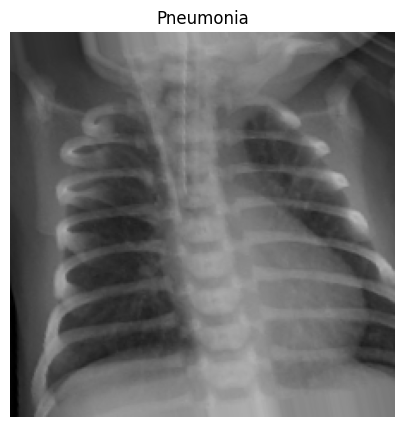

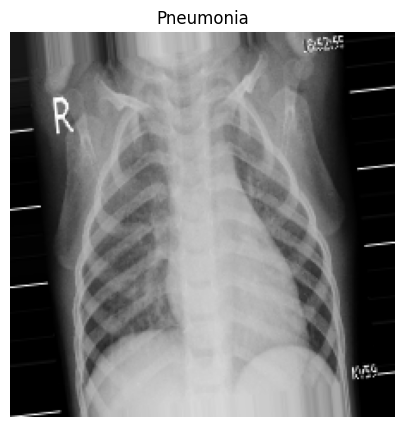

In [ ]:
import matplotlib.pyplot as plt

# First batch
images, labels = train[0]

plt.figure(figsize=(5, 5))
# First image in the batch
plt.imshow(images[0], cmap='gray')
# First label in the batch
plt.title("Pneumonia" if labels[0] == 1 else "Normal")  # Note: 1 = Pneumonia, 0 = Normal based on your folder structure
plt.axis('off')
plt.show()

# Last batch
last_batch_index = len(train) - 1
images, labels = train[last_batch_index]

plt.figure(figsize=(5, 5))
plt.imshow(images[30], cmap='gray')
plt.title("Pneumonia" if labels[0] == 1 else "Normal")
plt.axis('off')
plt.show()


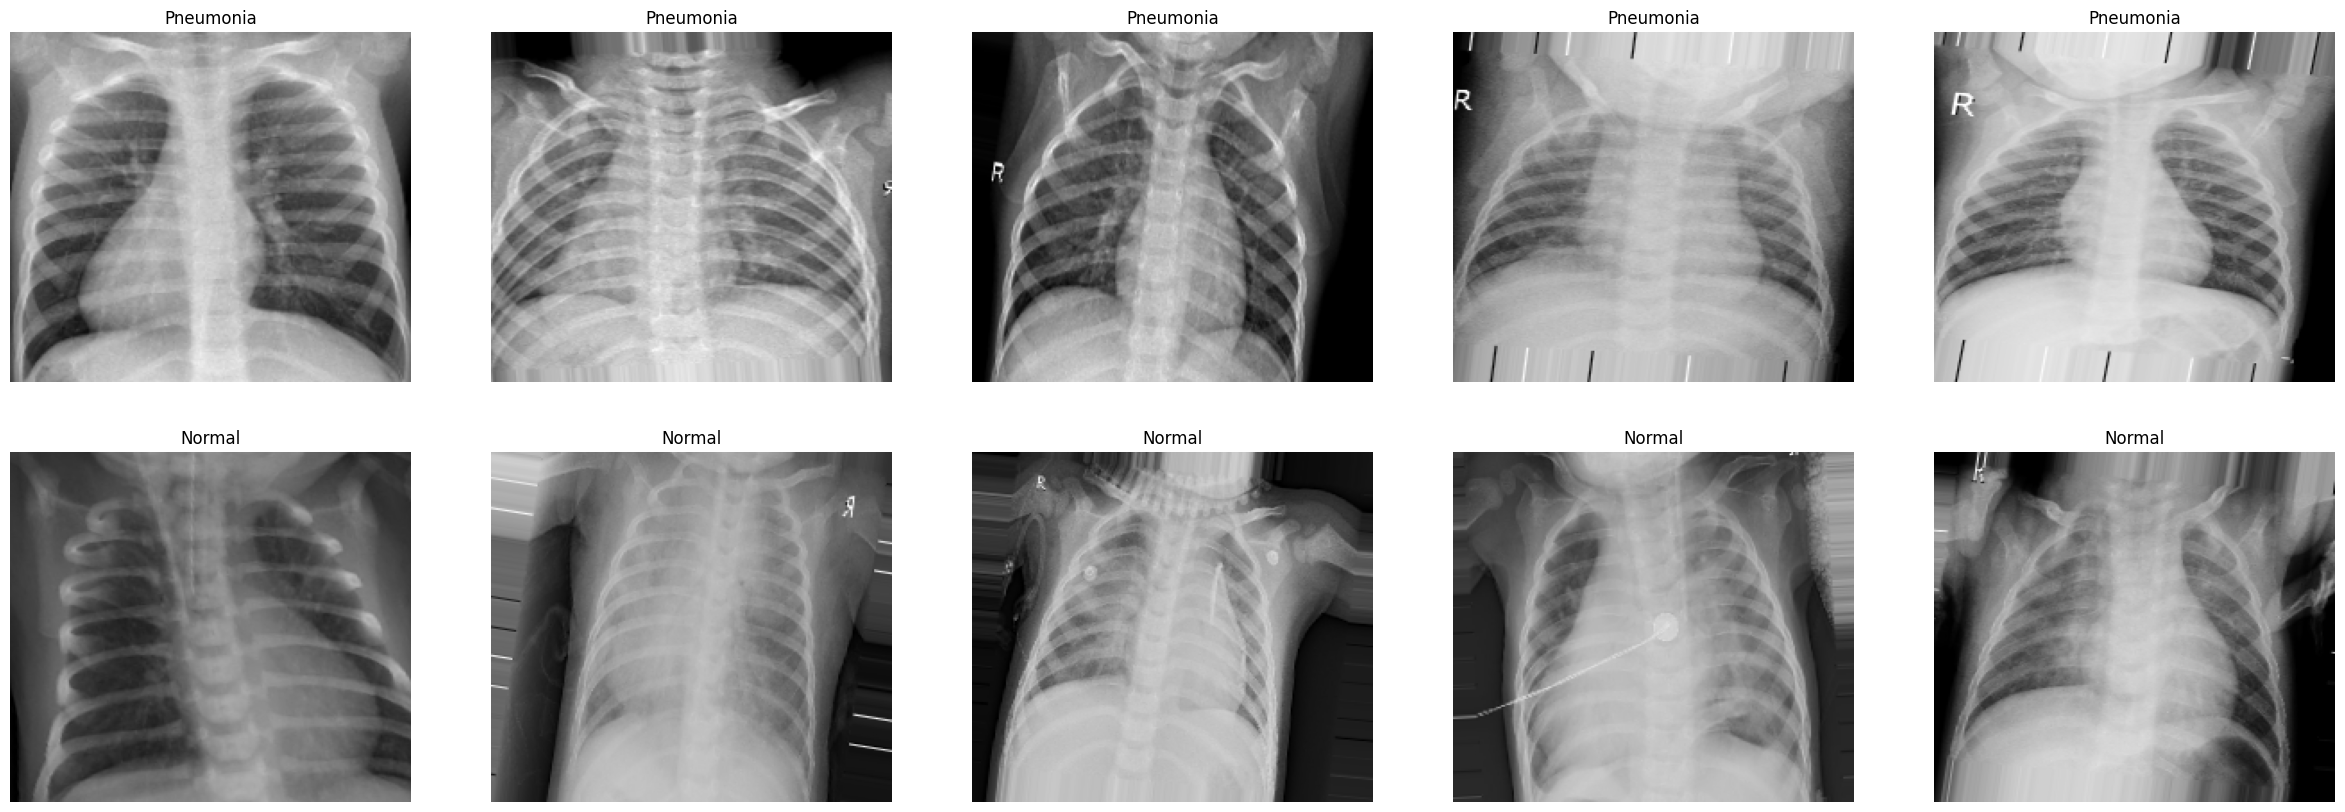

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get the total number of batches
total_batches = len(train)

# Initialize empty lists to store samples
pneumonia_samples = []
normal_samples = []

# Iterate through a subset of batches (e.g., the first 5 batches)
for batch_index in range(min(total_batches, 5)):  # Adjust the range if needed
    # Get a batch of data
    batch_data, batch_labels = train[batch_index]

    # Collect samples based on labels
    for i in range(len(batch_labels)):
        if batch_labels[i] == 0:  # Assuming 0 represents Pneumonia
            pneumonia_samples.append(batch_data[i])
        else:
            normal_samples.append(batch_data[i])

# Limit to 5 samples per class
pneumonia_samples = pneumonia_samples[:5]
normal_samples = normal_samples[:5]

samples = pneumonia_samples + normal_samples

# Plot the data
f, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(10):
    ax[i // 5, i % 5].imshow(samples[i], cmap='gray')
    if i < 5:
        ax[i // 5, i % 5].set_title("Pneumonia")
    else:
        ax[i // 5, i % 5].set_title("Normal")
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')
plt.show()

In [ ]:
def build_model(base_model, freeze_layers=True):
    if freeze_layers:
        base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
models = {
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'MobileNetV2': MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'EfficientNetB0': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
for name, base in models.items():
    print(f"Evaluating {name}")
    model = build_model(base, freeze_layers=False)
    model.fit(train, validation_data=test, epochs=20)
    loss, acc = model.evaluate(test)
    print(f"{name} Test Accuracy: {acc:.4f}")


Evaluating VGG16


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 1402s 8s/step - accuracy: 0.8383 - loss: 0.3728 - val_accuracy: 0.8862 - val_loss: 0.2804
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 881ms/step - accuracy: 0.9319 - loss: 0.1765 - val_accuracy: 0.8446 - val_loss: 0.3306
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 883ms/step - accuracy: 0.9570 - loss: 0.1173 - val_accuracy: 0.9135 - val_loss: 0.3682
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 877ms/step - accuracy: 0.9604 - loss: 0.1144 - val_accuracy: 0.9135 - val_loss: 0.2460
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 870ms/step - accuracy: 0.9635 - loss: 0.1045 - val_accuracy: 0.8862 - val_loss: 0.3699
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 883ms/step - accuracy: 0.9587 - loss: 0.1135 - val_accuracy: 0.9199 - val_loss: 0.1978
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 146s 894ms/step - accuracy: 0.9713 - loss: 0.0799 - val_accuracy: 0.9199 - val_loss: 0.3012
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 903ms/step - accuracy: 0.9755 - l

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,556,960 (47.90 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,343,292 (31.83 MB)

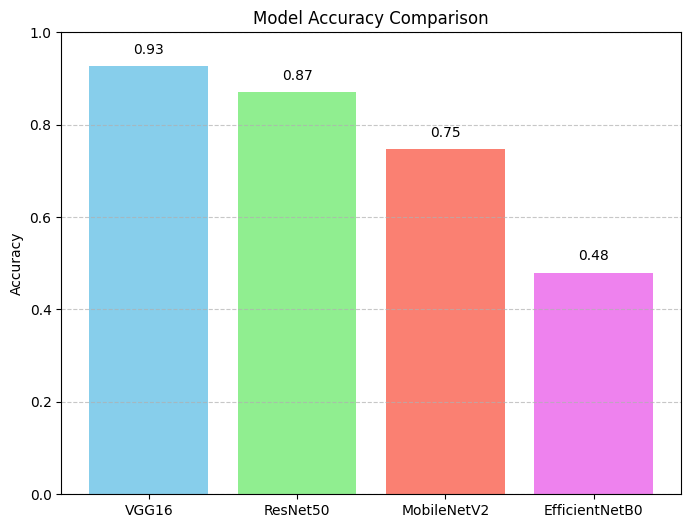

In [ ]:
import matplotlib.pyplot as plt

# Accuracy results you observed (you can adjust if you get updated numbers)
model_names = ['VGG16', 'ResNet50', 'MobileNetV2', 'EfficientNetB0']
accuracies = [0.9263, 0.8702, 0.7468, 0.48]  # Update EfficientNetB0 final accuracy if you have it

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'violet'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
